In [1]:
import signac
import numpy as npt
import matplotlib.pyplot as plt
import numpy as np

In [2]:
project = signac.get_project()

In [12]:
project.detect_schema()

ProjectSchema(<len=16>)

In [58]:
sample_job = list(project.find_jobs())[0]
eq_start = int(sample_job.statepoint.n_steps[0]/sample_job.statepoint.energy_write_freq) + 1
eq_start

50001

In [16]:
sample_job.statepoint

{'n_density': 0.35, 'n_particles': 100, 'r': 0.5, 'r_cut': 2.5, 'energy_func': 'lj', 'hard_sphere': False, 'epsilon': 1.0, 'sigma': 0.5, 'n': 12, 'm': 6, 'energy_write_freq': 1000, 'trajectory_write_freq': 10000, 'n_steps': [50000000.0, 100000000.0], 'kT': [10, 3.8], 'max_trans': [0.5, 0.5], 'seed': 20}

In [73]:
def get_energies(text_file, start):
    array = np.loadtxt(text_file, dtype=str)[start:]
    return np.asarray([float(a.split(',')[0]) for a in array])
    

In [174]:
import gsd.hoomd
import freud
def rdf(gsd_file, start=0, stop=-1, bins=30, r_max=2):
    with gsd.hoomd.open(gsd_file, "rb") as f:
        rdf = freud.density.RDF(bins, r_max)
        for snap in f[start:stop]:
            box = snap.configuration.box
            points = snap.particles.position
            rdf.compute((box,points))
    return rdf

def rdf_peak(rdf):
    return rdf[find_peaks(rdf)[0][0]]

In [130]:

def avg_nn(gsd_file, frame=-1, r_max=3):
    with gsd.hoomd.open(gsd_file) as f:
        snap = f[frame]
        box = snap.configuration.box
        points = snap.particles.position
        frame_avg_nn = []
        aq = freud.locality.AABBQuery(box, points)
        nlist = aq.query(points, {'r_max': 3}).toNeighborList()
        neighbors = []
        for i in range(snap.particles.N):
            neighbors.append(np.where(nlist[:, 0] == i)[0].shape[0]-1)
            frame_avg_nn.append(np.average(neighbors))
    return np.average(frame_avg_nn)

In [169]:
rd = rdf(job.fn('trajectory_1.gsd'))

In [120]:
rd.rdf

array([ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        7.466453 , 18.675554 , 15.808517 ,  9.036184 , 15.666558 ,
        6.8554654,  9.074895 ,  8.067684 ,  7.219268 , 19.493956 ,
        7.839481 ,  8.90914  , 13.015932 ,  2.982977 ,  6.8611774,
        7.6004105,  5.8647356,  7.6243963, 10.141157 ,  5.679201 ,
        7.9693756,  7.4714766,  5.4590793,  5.8720274,  4.8445253,
        1.3072736,  7.41974  ,  2.3431144,  3.8902223,  5.807601 ,
        2.5110664,  4.3047433,  5.472738 ,  3.4826765,  4.1599092,
        4.77488  ,  3.8097622,  4.381267 ,  4.2024636,  3.6981812],
      dtype=float32)

In [141]:
from scipy.signal import find_peaks

In [171]:
rd.rdf[find_peaks(rd.rdf)[0][0]]

90.45856

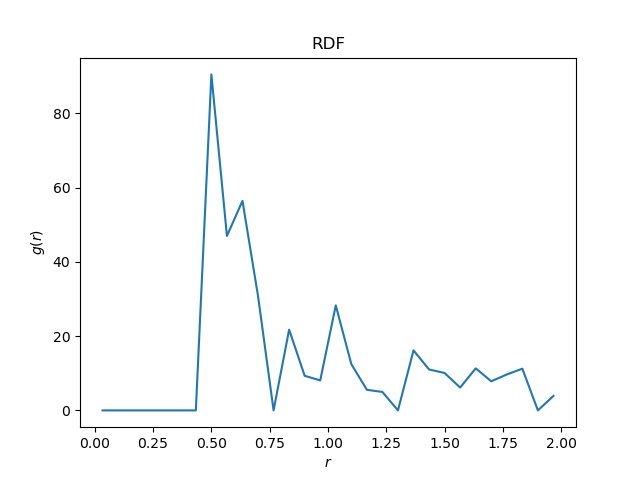

<Figure size 640x480 with 0 Axes>

In [170]:
rd

In [154]:
rd.rdf[6]

28.369759

In [124]:
rd.n_r

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02      , 0.08      , 0.14      , 0.18      , 0.26      ,
       0.29999998, 0.35999998, 0.42      , 0.48      , 0.65999997,
       0.73999995, 0.8399999 , 0.9999999 , 1.0399998 , 1.1399999 ,
       1.2599999 , 1.3599999 , 1.4999999 , 1.6999998 , 1.8199998 ,
       1.9999998 , 2.1799998 , 2.32      , 2.48      , 2.6200001 ,
       2.66      , 2.9       , 2.98      , 3.1200001 , 3.3400002 ,
       3.44      , 3.6200001 , 3.8600001 , 4.02      , 4.22      ,
       4.4599996 , 4.6599994 , 4.899999  , 5.139999  , 5.3599987 ],
      dtype=float32)

In [134]:
np.nonzero(rd.rdf)[0][0]

10

In [132]:
rd.bin_centers[10]

0.41999998688697815

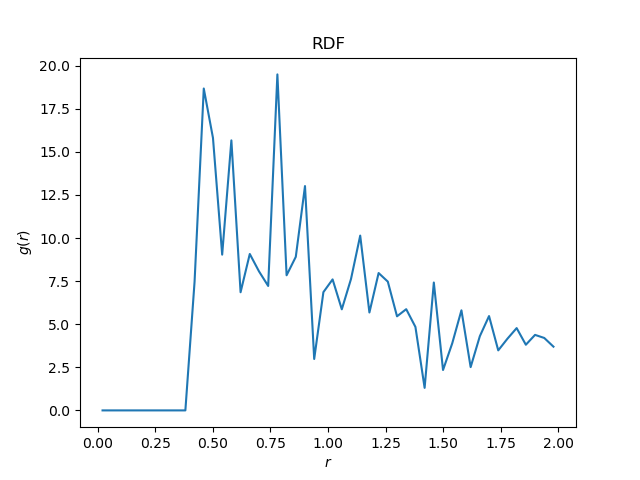

<Figure size 640x480 with 0 Axes>

In [127]:
rd

In [135]:
rd.rdf[10]

7.466453

In [175]:
avg_energy_list=[]
std_energy_list = []
avg_nn_list = []
rdf_list = []
n_density_list =[]
kT_list = []
for k, group in project.find_jobs().groupby(("n_density", "kT")):
    n_density = k[0]
    kT = k[1][1]
    n_density_list.append(n_density)
    kT_list.append(kT)
    job = list(group)[0]
    energies = get_energies(job.fn("log.txt"), eq_start)
    avg_energy_list.append(np.average(energies))
    std_energy_list.append(np.std(energies))
    
    gsd_file = job.fn('trajectory_1.gsd')
    avg_nn_list.append(avg_nn(gsd_file))
    rd = rdf(gsd_file).rdf
    rdf_list.append(rdf_peak(rd))
    
    


Text(0, 0.5, 'T')

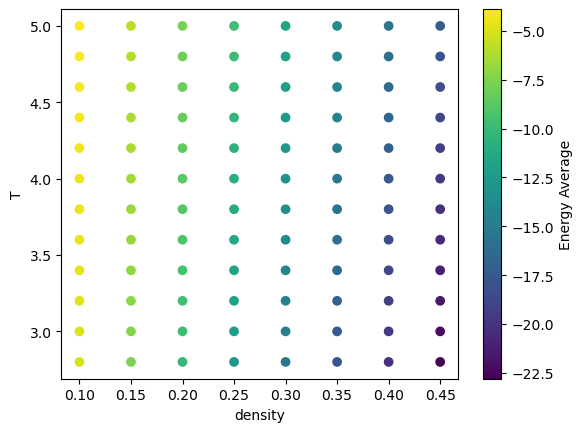

In [177]:
plt.scatter(n_density_list, kT_list, c=avg_energy_list, cmap='viridis')
plt.colorbar(label="Energy Average")
plt.xlabel("density")
plt.ylabel("T")


Text(0, 0.5, 'T')

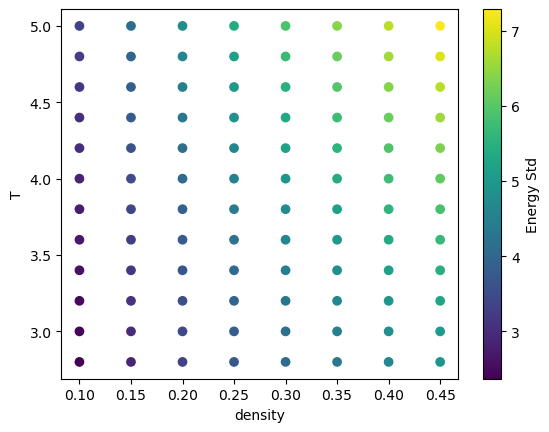

In [178]:
plt.scatter(n_density_list, kT_list, c=std_energy_list, cmap='viridis')
plt.colorbar(label="Energy Std")
plt.xlabel("density")
plt.ylabel("T")


Text(0, 0.5, 'T')

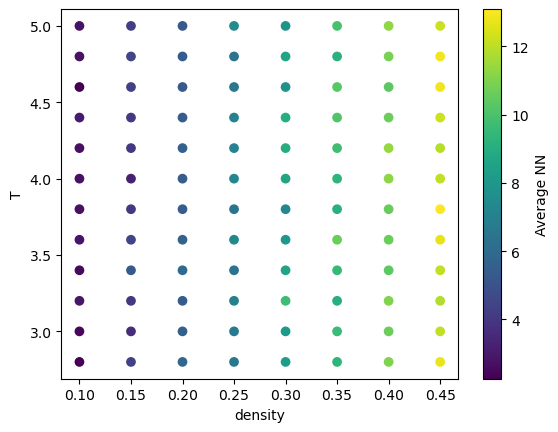

In [179]:
plt.scatter(n_density_list, kT_list, c=avg_nn_list, cmap='viridis')
plt.colorbar(label="Average NN")
plt.xlabel("density")
plt.ylabel("T")


Text(0, 0.5, 'T')

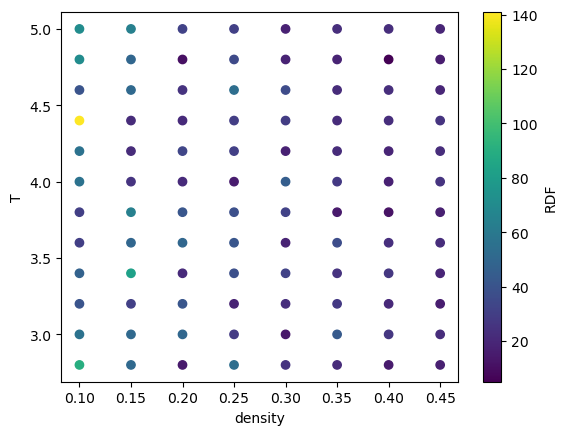

In [180]:
plt.scatter(n_density_list, kT_list, c=rdf_list, cmap='viridis')
plt.colorbar(label="RDF")
plt.xlabel("density")
plt.ylabel("T")
